In [2]:
import gdown
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# 下載 bid 文件
file_id_bid = '1MNq6FUFgjWLrJidHNy-opCGsooKmZLyx'
url_bid = f"https://drive.google.com/uc?export=download&id={file_id_bid}"
output_bid = 'data_bid.csv'
gdown.download(url_bid, output_bid, quiet=False)

# 下載 ask 文件
file_id_ask = '1G69ztxdvpDx6u6nLJdy-VfiLZCcIKk0c'
url_ask = f"https://drive.google.com/uc?export=download&id={file_id_ask}"
output_ask = 'data_ask.csv'
gdown.download(url_ask, output_ask, quiet=False)

# 讀取下載的文件
data_bid = pd.read_csv('data_bid.csv')
data_ask = pd.read_csv('data_ask.csv')

Downloading...
From: https://drive.google.com/uc?export=download&id=1MNq6FUFgjWLrJidHNy-opCGsooKmZLyx
To: /content/data_bid.csv
100%|██████████| 37.6M/37.6M [00:00<00:00, 156MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1G69ztxdvpDx6u6nLJdy-VfiLZCcIKk0c
To: /content/data_ask.csv
100%|██████████| 37.5M/37.5M [00:00<00:00, 147MB/s]


In [3]:
# 使用左外連接合併，這樣假設bid的數據筆數多，它的數據不會遺失
data = pd.merge(data_bid, data_ask, on='Local time', how='left')

# 使用fillna填充NaN值，你可以使用特定值或其他策略，這裡我用0作為例子
data = data.fillna(0)

# 計算平均價格
data['Average_Open'] = (data['Open_x'] + data['Open_y']) / 2
data['Average_High'] = (data['High_x'] + data['High_y']) / 2
data['Average_Low'] = (data['Low_x'] + data['Low_y']) / 2
data['Average_Close'] = (data['Close_x'] + data['Close_y']) / 2
data['Total_Volume'] = data['Volume_x'] + data['Volume_y']
columns_to_drop = ['Open_x', 'Open_y', 'High_x', 'High_y', 'Low_x', 'Low_y', 'Close_x', 'Close_y', 'Volume_x', 'Volume_y']
data = data.drop(columns=columns_to_drop)
print(data.head())

                         Local time  Average_Open  Average_High  Average_Low  \
0  15.07.2022 00:00:00.000 GMT+0800       1.00274      1.002800     1.002660   
1  15.07.2022 00:01:00.000 GMT+0800       1.00267      1.002745     1.002410   
2  15.07.2022 00:02:00.000 GMT+0800       1.00273      1.002925     1.002635   
3  15.07.2022 00:03:00.000 GMT+0800       1.00281      1.003210     1.002795   
4  15.07.2022 00:04:00.000 GMT+0800       1.00321      1.003220     1.002900   

   Average_Close  Total_Volume  
0       1.002685       1471.87  
1       1.002735       1441.20  
2       1.002825       1400.99  
3       1.003195       1289.15  
4       1.003100       1393.34  


In [4]:
# 計算價格和成交量的變化
data['Price_Change'] = data['Average_Close'].pct_change()
data['Volume_Change'] = data['Total_Volume'].pct_change()
# 創建未來三分鐘的收盤價欄位
data['Future_Close'] = data['Average_Close'].shift(-3)
data['three_minutes_Change'] = data['Future_Close'] - data['Average_Open']
# 處理缺失值和無窮大
data.replace([np.inf, -np.inf], np.nan, inplace=True)

missing_cols = data.columns[data.isnull().any()]
for col in missing_cols:
    data[col].fillna(data[col].median(), inplace=True)
# 嘗試使用完整的格式轉換日期時間
data['Local time'] = pd.to_datetime(data['Local time'], format='%d.%m.%Y %H:%M:%S.000 GMT+0800', errors='coerce')

# 對於剩下的非NaT項目，再次嘗試使用不帶GMT部分的基本格式轉換
data.loc[data['Local time'].isna(), 'Local time'] = pd.to_datetime(data[data['Local time'].isna()]['Local time'], format='%d.%m.%Y %H:%M:%S')
delete_condition = (
    ((data['Local time'].dt.weekday == 5) & (data['Local time'].dt.hour >= 5)) |
    (data['Local time'].dt.weekday == 6) |
    ((data['Local time'].dt.weekday == 0) & (data['Local time'].dt.hour < 5))
)
late_market_open_condition = (
    (data['Local time'].dt.weekday == 0) &
    (data['Local time'].dt.hour == 5) &
    (data['Local time'].dt.minute < 4) &
    (data['Total_Volume'] == 0)
)

# 組合上述兩個刪除條件
combined_delete_condition = delete_condition | late_market_open_condition
data.drop(data[combined_delete_condition].index, inplace=True)
data.reset_index(drop=True, inplace=True)

print(data.head(23338))

               Local time  Average_Open  Average_High  Average_Low  \
0     2022-07-15 00:00:00      1.002740      1.002800     1.002660   
1     2022-07-15 00:01:00      1.002670      1.002745     1.002410   
2     2022-07-15 00:02:00      1.002730      1.002925     1.002635   
3     2022-07-15 00:03:00      1.002810      1.003210     1.002795   
4     2022-07-15 00:04:00      1.003210      1.003220     1.002900   
...                   ...           ...           ...          ...   
23333 2022-08-06 04:58:00      1.018080      1.018285     1.017910   
23334 2022-08-06 04:59:00      1.018045      1.018430     1.017850   
23335 2022-08-08 05:02:00      1.017565      1.017565     1.017565   
23336 2022-08-08 05:03:00      1.017820      1.017855     1.017820   
23337 2022-08-08 05:04:00      1.017870      1.017870     1.017820   

       Average_Close  Total_Volume  Price_Change  Volume_Change  Future_Close  \
0           1.002685       1471.87      0.000000      -0.008675      1.003195 

In [5]:
# 將價格變動轉換為類別
def label(three_minutes_Change):
    if three_minutes_Change > 0:
        return 2
    elif three_minutes_Change < 0:
        return 0
    else:
        return 1

data['Label'] = data['three_minutes_Change'].apply(label)

# 提取日期時間特徵
data['Local time'] = pd.to_datetime(data['Local time'])
data['Year'] = data['Local time'].dt.year
data['Month'] = data['Local time'].dt.month
data['Day'] = data['Local time'].dt.day
data['DayOfWeek'] = data['Local time'].dt.dayofweek
data['Hour'] = data['Local time'].dt.hour
data['Minute'] = data['Local time'].dt.minute

# 轉換日期時間特徵為循環特徵
data['DayOfWeekSin'] = np.sin((data['DayOfWeek']) * (2. * np.pi / 7))
data['DayOfWeekCos'] = np.cos((data['DayOfWeek']) * (2. * np.pi / 7))
data['HourSin'] = np.sin(data['Hour'] * (2. * np.pi / 24))
data['HourCos'] = np.cos(data['Hour'] * (2. * np.pi / 24))

# 去掉不需要的列
data = data.drop('Local time', axis=1)

# 定義特徵和目標變量
features = [
    "Average_Open", "Average_Close", "Total_Volume", "Price_Change", "Volume_Change",
    "Year", "Month", "Day", "Hour", "Minute",
    "DayOfWeek", "DayOfWeekSin", "DayOfWeekCos", "HourSin", "HourCos"
]
label = "Label"

# 按照時間順序分割訓練集和測試集
train_size = round(len(data) * 0.9)
train_data = data.iloc[:train_size].copy()
test_data = data.iloc[train_size:].copy()

# 計算訓練數據的滑動窗口標準差
window_size = 5
train_data['Std_Dev'] = train_data['Average_Close'].rolling(window_size).std()

# 計算測試數據的滑動窗口標準差
test_data['Std_Dev'] = test_data['Average_Close'].rolling(window_size).std()

# 補充 features 以包括 'Std_Dev'
features.append('Std_Dev')

x_train = train_data[features]
y_train = train_data[label]
x_test = test_data[features]
y_test = test_data[label]

x_train = x_train.fillna(x_train.mean())
x_test = x_test.fillna(x_train.mean())

# 資料正規化
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


In [6]:
#邏輯回歸
model = LogisticRegression(max_iter=1000)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Confusion Matrix: \n', confusion_matrix(y_test, y_pred))


Accuracy:  0.6428476451346967
Confusion Matrix: 
 [[ 9738     0  8325]
 [  195     0   542]
 [ 4368     0 14435]]


In [ ]:
from sklearn.metrics import classification_report
print('Classification Report for Test Set: \n', classification_report(y_test, y_pred, digits=5))

Classification Report for Test Set: 
               precision    recall  f1-score   support

           0    0.68093   0.53911   0.60178     18063
           1    0.00000   0.00000   0.00000       737
           2    0.61947   0.76770   0.68567     18803

    accuracy                        0.64285     37603
   macro avg    0.43347   0.43560   0.42915     37603
weighted avg    0.63685   0.64285   0.63193     37603



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.inspection import permutation_importance

# 1. 使用模型在測試集上計算 Permutation Importance
result = permutation_importance(model, x_test, y_test, n_repeats=30, random_state=0)

# 2. 根据重要性排序特征
sorted_indices = result.importances_mean.argsort()[::-1]

# 3. 打印特征和其对应的重要性
print("Feature Importance:")
for idx in sorted_indices:
    print(f"{features[idx]:<20} : {result.importances_mean[idx]:.4f} ± {result.importances_std[idx]:.4f}")


Feature Importance:
Average_Close        : 0.1539 ± 0.0023
Average_Open         : 0.1496 ± 0.0024
DayOfWeek            : 0.0023 ± 0.0010
DayOfWeekCos         : 0.0006 ± 0.0005
Month                : 0.0003 ± 0.0003
Hour                 : 0.0001 ± 0.0001
Day                  : 0.0001 ± 0.0001
Minute               : 0.0000 ± 0.0002
DayOfWeekSin         : 0.0000 ± 0.0005
Year                 : 0.0000 ± 0.0000
Total_Volume         : -0.0000 ± 0.0001
Std_Dev              : -0.0001 ± 0.0001
Price_Change         : -0.0001 ± 0.0001
Volume_Change        : -0.0001 ± 0.0001
HourCos              : -0.0003 ± 0.0004
HourSin              : -0.0022 ± 0.0007


In [ ]:
# 預測和評估
y_pred = model.predict(x_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix: \n', conf_matrix)

def calculate_profit(conf_matrix):
    profit = 0

    # 標籤0且預測為0，獲利0.9
    profit += conf_matrix[0, 0] * 0.9

    # 標籤0但預測為2，損失1
    if conf_matrix.shape[1] > 2:
        profit -= conf_matrix[0, 2]

    # 標籤2且預測為2，獲利0.9
    if conf_matrix.shape[0] > 2 and conf_matrix.shape[1] > 2:
        profit += conf_matrix[2, 2] * 0.9

    # 標籤2但預測為0，損失1
    if conf_matrix.shape[0] > 2:
        profit -= conf_matrix[2, 0]

    return profit


profit = calculate_profit(conf_matrix)
print("總獲利：", profit)



Accuracy:  0.642767864266149
Confusion Matrix: 
 [[ 9725     0  8338]
 [  195     0   542]
 [ 4358     0 14445]]
總獲利： 9057.0


In [28]:
def martingale_strategy(predictions, true_values, verbose=False):
    balance = 0  # 起始餘額為0，代表沒有任何本金
    bet = 1  # 初始投注金額

    for i, (pred, true) in enumerate(zip(predictions, true_values)):
        if pred == true:  # 預測正確，贏得賭注
            balance += 0.9 * bet
            if verbose:
                print(f"Trade {i + 1}: WIN  | Bet: ${bet} | Balance: ${round(balance, 1)}")
            bet = 1
        else:  # 預測錯誤，輸掉賭注
            balance -= bet
            if verbose:
                print(f"Trade {i + 1}: LOSE | Bet: ${bet} | Balance: ${round(balance, 1)}")
            bet *= 2.11092  # 加倍投注金額

    return round(balance, 1)  # 返回淨利潤


subset_size = 8000
x_test_subset = x_test[:subset_size]
y_test_subset = y_test[:subset_size]

# 使用模型進行預測
y_pred_subset = model.predict(x_test_subset)

# 計算馬丁格爾策略淨利潤
print("Martingale Strategy:")
profit_martingale = martingale_strategy(y_pred_subset, y_test_subset, verbose=True)

print("\n總獲利:", profit_martingale)


串流輸出內容已截斷至最後 5000 行。
Trade 3003: LOSE | Bet: $1 | Balance: $1734.6
Trade 3004: WIN  | Bet: $2.11092 | Balance: $1736.5
Trade 3005: LOSE | Bet: $1 | Balance: $1735.5
Trade 3006: LOSE | Bet: $2.11092 | Balance: $1733.4
Trade 3007: LOSE | Bet: $4.455983246400001 | Balance: $1728.9
Trade 3008: WIN  | Bet: $9.40622415449069 | Balance: $1737.4
Trade 3009: LOSE | Bet: $1 | Balance: $1736.4
Trade 3010: WIN  | Bet: $2.11092 | Balance: $1738.3
Trade 3011: WIN  | Bet: $1 | Balance: $1739.2
Trade 3012: WIN  | Bet: $1 | Balance: $1740.1
Trade 3013: WIN  | Bet: $1 | Balance: $1741.0
Trade 3014: LOSE | Bet: $1 | Balance: $1740.0
Trade 3015: WIN  | Bet: $2.11092 | Balance: $1741.9
Trade 3016: WIN  | Bet: $1 | Balance: $1742.8
Trade 3017: LOSE | Bet: $1 | Balance: $1741.8
Trade 3018: LOSE | Bet: $2.11092 | Balance: $1739.7
Trade 3019: LOSE | Bet: $4.455983246400001 | Balance: $1735.2
Trade 3020: WIN  | Bet: $9.40622415449069 | Balance: $1743.7
Trade 3021: LOSE | Bet: $1 | Balance: $1742.7
Trade 3022: W

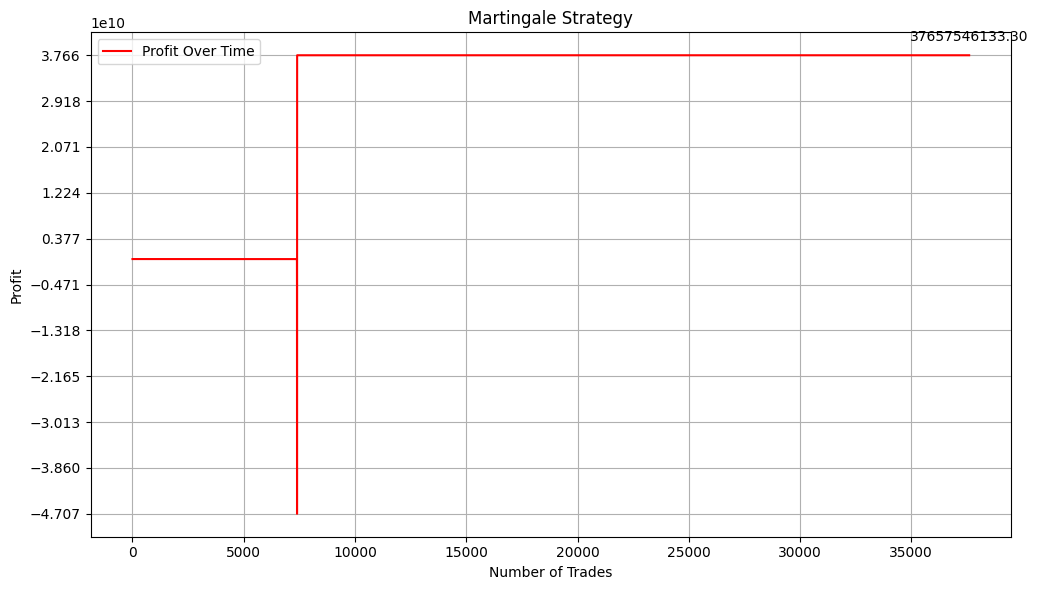

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def martingale_strategy(predictions, true_values):
    balances = []
    balance = 0
    bet = 1

    for i, (pred, true) in enumerate(zip(predictions, true_values)):
        if pred == true:
            balance += 0.9 * bet
            bet = 1
        else:
            balance -= bet
            bet *= 3
        balances.append(balance)

    return balances


predictions = model.predict(x_test_subset)
balances = martingale_strategy(predictions, y_test)  # 使用模型的預測結果和真實結果


plt.figure(figsize=(10, 6))
plt.plot(balances, label="Profit Over Time", color="red")
plt.xlabel("Number of Trades")
plt.ylabel("Profit")
plt.title("Martingale Strategy")
plt.grid(True)
plt.legend()
plt.tight_layout()

min_balance = min(balances)
max_balance = max(balances)
yticks_interval = (max_balance - min_balance) / 10
plt.yticks(np.arange(min_balance, max_balance + yticks_interval, yticks_interval))

final_balance = balances[-1]
plt.annotate(f"{final_balance:.2f}", (len(balances)-1, final_balance), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()

In [ ]:
def martingale_strategy(predictions, true_values):
    initial_balance = 1000
    balance = initial_balance
    bet = 1  # 初始投注金額

    for i, (pred, true) in enumerate(zip(predictions, true_values)):
        if pred == true:  # 預測正確，贏得賭注
            balance += 0.9 * bet
            bet = 1
        else:  # 預測錯誤，輸掉賭注
            balance -= bet
            bet *= 2  # 加倍投注金額

            # 確保投注金額不超過餘額
            if bet > balance:
                bet = balance

            # 檢查是否已經超過了預設的本金上限
            if balance <= 0:
                break

    return round(balance - initial_balance, 1)  # 返回淨利潤

# 使用上述的martingale_strategy函數進行交易策略模擬

subset_size = 200
x_test_subset = x_test[:subset_size]
y_test_subset = y_test[:subset_size]

# 使用模型進行預測
y_pred_subset = model.predict(x_test_subset)

# 計算馬丁格爾策略淨利潤
total_profit_martingale = martingale_strategy(y_pred_subset, y_test_subset)
print("Total Profit with Martingale Strategy:", total_profit_martingale)


Total Profit with Martingale Strategy: 105.5
